# Playground lmd_viz

> Playground notebook for https://github.com/matthieuvion/lmd_viz.  


In [5]:
import polars as pl
import pandas as pd
import numpy as np
from datetime import datetime, date
import pickle

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from sentence_transformers import SentenceTransformer
import faiss

## Inside

`lmd_viz` aims at analyzing (superficially) comments wrote on Le Monde during the "1st" year (Febr 2022) of conflict in Ukraine. As reader of Le Monde I would encounter familiar suscribers' pseudo in the readers comment section and also was curious to what extent people engagement with the topic would vary over time.
- Source data is an open-source dataset previously scrapped from Le Monde (cf.repo)
- Use of `Polars` as an alternative to Pandas, tho we still use Pandas to make it easier/faster to experiment; Plotly to visualize.
- Semantic search via Sentence Transformer embeddings (SBERT) + Faiss index, quick benchmark on models

In [6]:
# Polars, render text columns nicer when printing / displaying df
pl.Config.set_fmt_str_lengths(100)
pl.Config.set_tbl_cols(12)
pl.Config.set_tbl_width_chars(200)
pl.Config.set_tbl_rows(10)

polars.config.Config

In [21]:
# change default plotly express theme
import plotly.io as pio
print(f" reminder plotly quick templates : {pio.templates}")
template = "simple_white"

 reminder plotly quick templates : Templates configuration
-----------------------
    Default template: 'plotly'
    Available templates:
        ['ggplot2', 'seaborn', 'simple_white', 'plotly',
         'plotly_white', 'plotly_dark', 'presentation', 'xgridoff',
         'ygridoff', 'gridon', 'none']



## Load Le Monde Ukraine Dataset

Info/download the dataset : see adjacent gh repo https://github.com/matthieuvion/lmd_ukr

In [22]:
# Read parquet using Polars
filepath = "data/lmd_ukraine.parquet"
coms = pl.read_parquet(filepath)
# Could also use print() for a different formatting
display(coms.head(1))
print(f"shape: {coms.shape}")
print(f"dtypes: {coms.dtypes}")

article_id,url,title,desc,content,date,keywords,article_type,allow_comments,premium,author,comment
i64,str,str,str,str,date,list[str],cat,bool,bool,str,str
3259703,"""https://www.lemonde.fr/actualite-medias/article/2022/07/16/au-festival-de-journalisme-de-couthures-…","""Le conflit russo-ukrainien, qui mobilise les médias depuis le 24 février, s’est tout naturellemen…","""Au Festival de journalisme de Couthures : la guerre, un sujet trop sérieux pour les seuls journali…","""Parce qu’elle est revenue frapper à nos portes, qu’elle a repris ses aises en Europe, le Festival …",2022-07-16,"[""international"", ""europe"", … ""festival-international-de-journalisme-de-couthures""]","""Factuel""",true,false,"""Ricardo Uztarroz""","""La question qui vaille et qui n'est pas posée dans cet article : celle des sources. En l'occurence…"


shape: (236643, 12)
dtypes: [Int64, Utf8, Utf8, Utf8, Utf8, Date, List(Utf8), Categorical, Boolean, Boolean, Utf8, Utf8]


## Order of magnitude ; articles, comments, authors

Reminder on dates:  
Start of conflict (not taking into account prior Dombass operations) is Febr, 24th 2022 ; our dataset covers the first year.  
Our data at a quick glance:  
How many / how big ? + Small editorial benchmarks with side quick scrapping on other topics to have more context

### Unique articles, comments count, unique authors

Using basic Polars methods, quite similar to Pandas except for the slicing

In [23]:
# n comments; can also simply use .shape
coms.select([
    pl.col('comment').count()
])

comment
u32
236643


In [24]:
# n unique articles
coms.select('article_id').n_unique()

2590

In [41]:
# n unique comments' authors
coms.select('author').n_unique()

10700

### Editorial & comment activity + elements of comparison

Our dataset excludes the "Lives" that represent a substancial effort from Le Monde in regards to Ukraine war's coverage.  
Just by reading Le Monde (or other newspapers) we know that they mobilized a lot of ressources to cover the conflict.  
Also, regularly lurking into comments section, I know the topic is quite engaging, but now we have the numbers.

In [36]:
# Activity avg posts or comments per day
days = 365
total_articles = 2590
total_comments = 236643

# articles, (excluding lives/blogs posts) per day
print(f"avg articles per day: {total_articles/days:.2f}")

# comments per day
print(f"avg comments per day: {total_comments/days:.2f}")

# avg n comments per article
print(f"avg comments per article: {total_comments/total_articles:.2f}")

avg articles per day: 7.10
avg comments per day: 648.34
avg comments per article: 91.37


As a confirmation, though the scopes are not exactly aligned (quick scrapping, one month + sampling) :  
Topic 1 : Réforme retraites, very hot topic during the same timeframe, extensive coverage by Le Monde. Whereas I selected the "hottest" **month** as a benchmark, figures (editorial/comments) are very similar to Ukraine coverage, on a **one year** period.  
Topic 2, Trump, an always active topic in any media (tho out of fashion), that is always commented. Suscribers' engagement level is more than twice as low.

In [39]:
# quick benchmark with two themes collected along side just to put some perspective on our data.
themes = ["réforme retraites", "Donald trump"]
n_articles = [374, 66] # obtained on 1 month data (jan/febr 2023, exhaustive/no sampling)
n_days = 31
from_sample_avg_comments_per_articles = [124, 40] # obtained from a sample of 20 articles for each theme.

for idx, theme in enumerate(themes):   
    print(f"Theme, {theme}:\n")
    print(f" - avg articles per day: {n_articles[idx]/n_days:.2f}")
    print(f" - avg comments per article: {from_sample_avg_comments_per_articles[idx]:.2f}\n")

Theme, réforme retraites:

 - avg articles per day: 12.06
 - avg comments per article: 124.00

Theme, Donald trump:

 - avg articles per day: 2.13
 - avg comments per article: 40.00



### Misc : editorial share (type of articles)

Excluding Lives. Also we will cut off the least represented editorial types (<= 20 articles) to lighten our pie chart.

In [137]:
# our dataset has one row per comments, we're interested in share of articles type only
# "deduplicate", keep only one article (article_id) per row
article_types = coms.groupby(by='article_id').first().select(['article_id', 'article_type'])
print(article_types)

shape: (2_590, 2)
┌────────────┬──────────────┐
│ article_id ┆ article_type │
│ ---        ┆ ---          │
│ i64        ┆ cat          │
╞════════════╪══════════════╡
│ 3279208    ┆ Portrait     │
│ 3288832    ┆ Décryptages  │
│ 3275080    ┆ Factuel      │
│ 3263184    ┆ Portrait     │
│ 3262176    ┆ Factuel      │
│ …          ┆ …            │
│ 3301039    ┆ Récit        │
│ 3308775    ┆ Décryptages  │
│ 3267079    ┆ Factuel      │
│ 3271879    ┆ Factuel      │
│ 3266823    ┆ Décryptages  │
└────────────┴──────────────┘


In [138]:
editorial_share = article_types.groupby(by='article_type').count()
print(editorial_share.sort('count', descending=True))

shape: (25, 2)
┌────────────────┬───────┐
│ article_type   ┆ count │
│ ---            ┆ ---   │
│ cat            ┆ u32   │
╞════════════════╪═══════╡
│ Factuel        ┆ 940   │
│ Décryptages    ┆ 310   │
│ Reportage      ┆ 303   │
│ Tribune        ┆ 225   │
│ Récit          ┆ 115   │
│ …              ┆ …     │
│ Lettre de…     ┆ 3     │
│ Nécrologie     ┆ 1     │
│ Archive        ┆ 1     │
│ Série          ┆ 1     │
│ Brève de liens ┆ 1     │
└────────────────┴───────┘


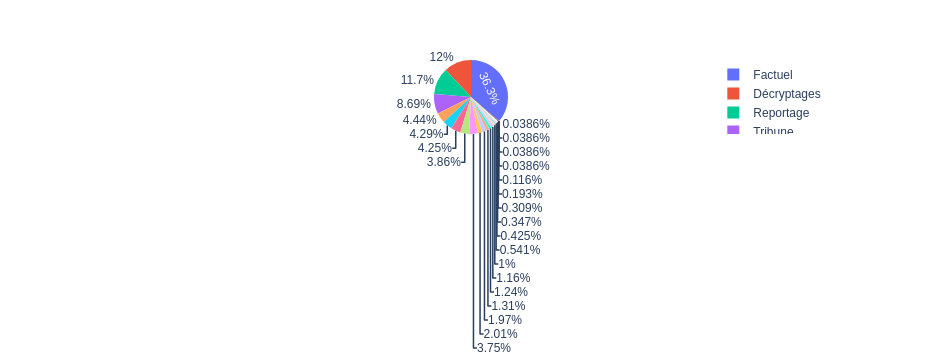

In [139]:
colors = ['gold', 'mediumturquoise', 'darkorange', 'lightgreen']
fig = px.pie(editorial_share.to_pandas(), values = 'count', names='article_type')
fig.show()

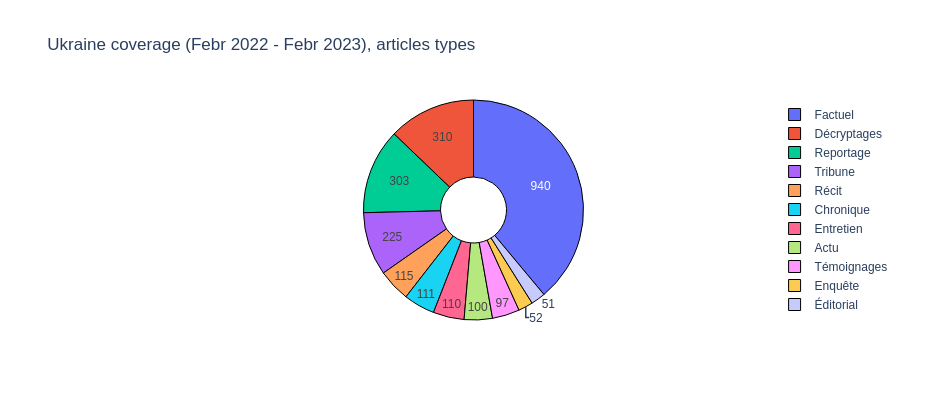

In [140]:
# stylize it a bit
editorial_share = editorial_share.filter(pl.col('count') >= 40)
labels = editorial_share.to_pandas()['article_type']
values = editorial_share.to_pandas()['count']
fig = go.Figure(data=[go.Pie(labels=labels, values=values)])
fig.update_traces(hoverinfo='label+percent+name', textinfo='value', textfont_size=12, hole = .3,
                  marker=dict(line=dict(color='#000000', width=1)))
fig.update_layout(title_text= 'Ukraine coverage (Febr 2022 - Febr 2023), articles types', height=400)
fig.show()

## People engagement over time, suscribers' comment activity as a proxy

General workflow : time series groupby / agg using Polars, then convert back aggs to Pandas for easier viz with Plotly.  
Experiment with diverse metrics/timespans to better analyze / render suscribers activity over this first year.  
**Tldr:** people activity keeps being high independently to Le Monde publication frequency. Some peaks in frequency would need further investigations but let's keep it simple.

Metrics/aggregations/rendering for comments :
> daily count  
> week / month avg  
> lines vs. hist  
> comments per article : daily / weekly  
> moving (=rolling) mean on a 30 days period



### Daily number of comments, weekly/monthly averages

In [156]:
# count comms per day
coms_daily_count = coms.groupby('date').count().sort('date', descending=False)
coms_daily_count.head(3)

date,count
date,u32
2022-02-24,3762
2022-02-25,2735
2022-02-26,785


In [162]:
# average per week and/or month (groupby window, using groupby_dynamic method in Polars)
weekly_avg = coms_daily_count.groupby_dynamic("date", every="1w").agg([pl.col('count').mean()])
display(weekly_avg.head(3))
monthly_avg = coms_daily_count.groupby_dynamic("date", every="1mo").agg([pl.col('count').mean()])
display(monthly_avg.head(3))

date,count
date,f64
2022-02-24,1520.0
2022-03-03,1743.666667
2022-03-10,1363.0


date,count
date,f64
2022-02-01,2427.333333
2022-03-01,1431.833333
2022-04-01,837.4


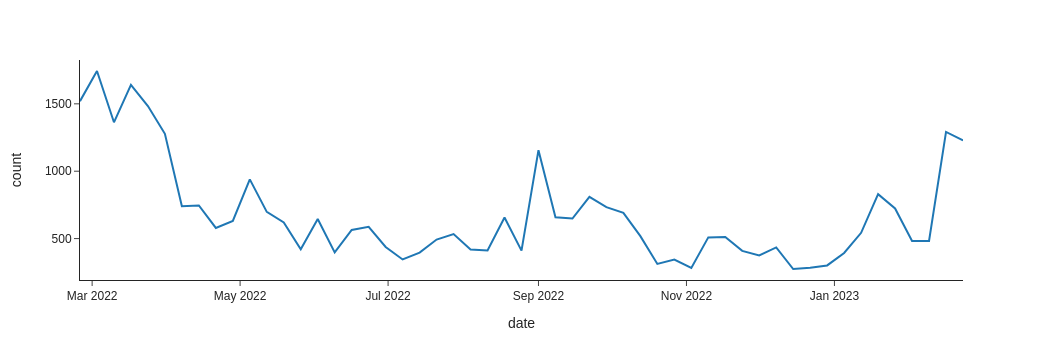

In [165]:
px.line(weekly_avg.to_pandas(), x="date", y="count", width=600, height=300, template=template)

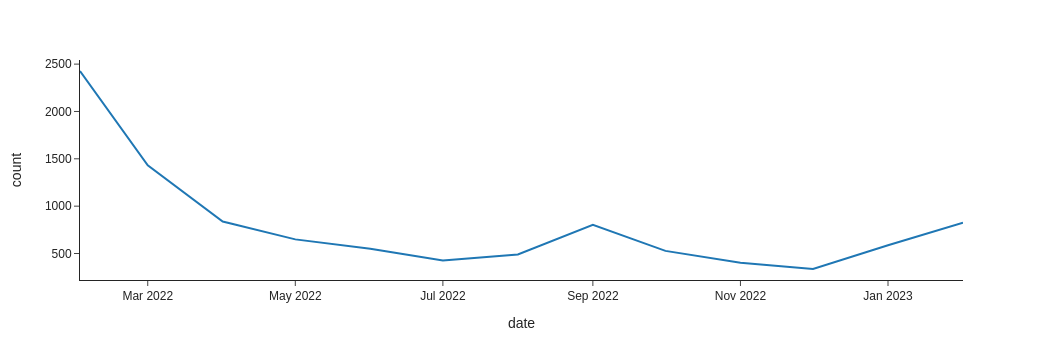

In [166]:
px.line(monthly_avg.to_pandas(), x="date", y="count", width=600, height=300, template=template)

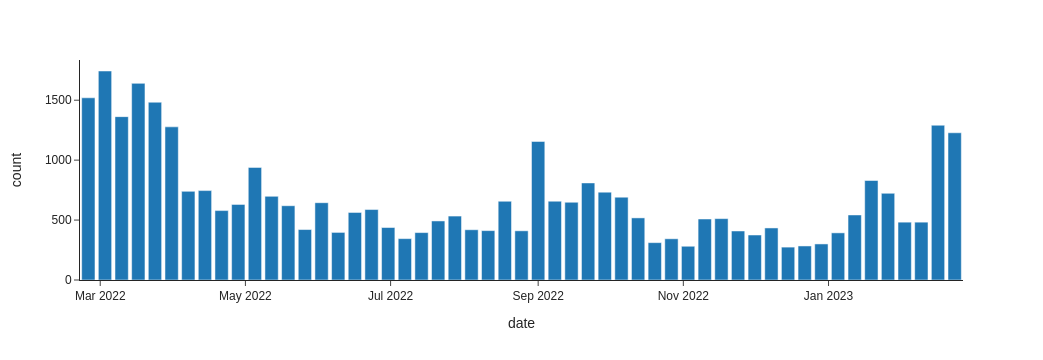

In [167]:
px.bar(weekly_avg.to_pandas(), x="date", y="count", width=600, height=300, template=template)

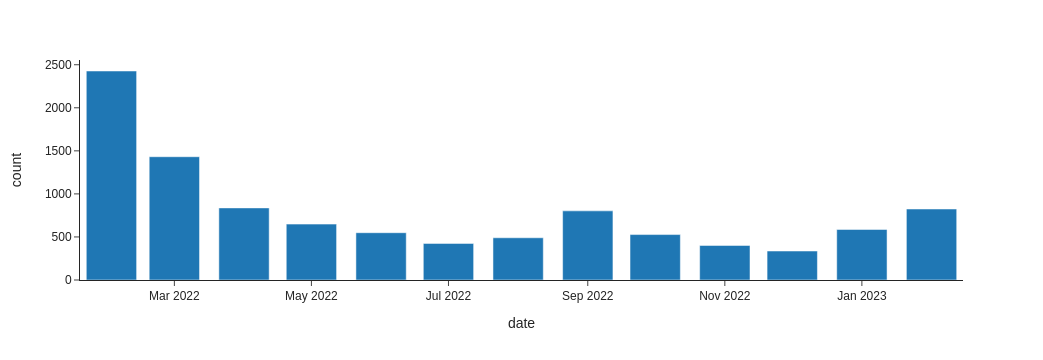

In [168]:
px.bar(monthly_avg.to_pandas(), x="date", y="count", width=600, height=300, template=template)

### Lower the impact of publication (articles) frequency : ratio comm per articles, rolling mean

Because number of commments probably tied to number of articles published by Le Monde

In [170]:
# daily coms per articles

# 1. groupby articles, count articles, count comments
daily_coms_per_articles = (
    coms.groupby(by="date").agg([
        pl.col('article_id').n_unique().alias('count_articles'),
        pl.col('comment').count().alias('count_comments')
    ]
    ).sort('date', descending=False)
)
display(daily_coms_per_articles.head(3))

# 2. coms per articles
daily_coms_per_articles = daily_coms_per_articles.with_columns(
    (pl.col('count_comments') / pl.col('count_articles')).alias('coms_per_article')
)
display(daily_coms_per_articles.head(3))

date,count_articles,count_comments
date,u32,u32
2022-02-24,36,3762
2022-02-25,30,2735
2022-02-26,7,785


date,count_articles,count_comments,coms_per_article
date,u32,u32,f64
2022-02-24,36,3762,104.5
2022-02-25,30,2735,91.166667
2022-02-26,7,785,112.142857


In [171]:
# weekly coms per articles

weekly_coms_per_articles = (
    coms.sort('date', descending=False).groupby_dynamic("date", every="1w").agg([
        pl.col('article_id').n_unique().alias('count_articles'),
        pl.col('comment').count().alias('count_comments')
    ]
    ).sort('date', descending=False)
)
display(weekly_coms_per_articles.head(3))

weekly_coms_per_articles = weekly_coms_per_articles.with_columns(
    (pl.col('count_comments') / pl.col('count_articles')).alias('coms_per_article')
)
display(weekly_coms_per_articles.head(3))

date,count_articles,count_comments
date,u32,u32
2022-02-24,78,7600
2022-03-03,130,10462
2022-03-10,125,9541


date,count_articles,count_comments,coms_per_article
date,u32,u32,f64
2022-02-24,78,7600,97.435897
2022-03-03,130,10462,80.476923
2022-03-10,125,9541,76.328


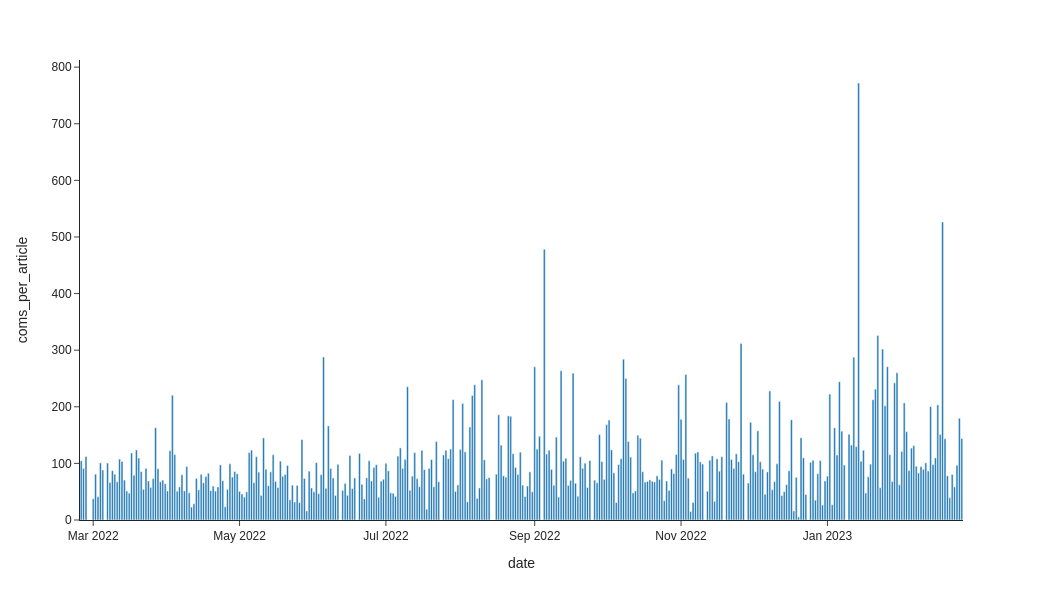

In [175]:
# daily coms per article over time
px.bar(daily_coms_per_articles.to_pandas(), x="date", y="coms_per_article", width=800, height=600, template=template)

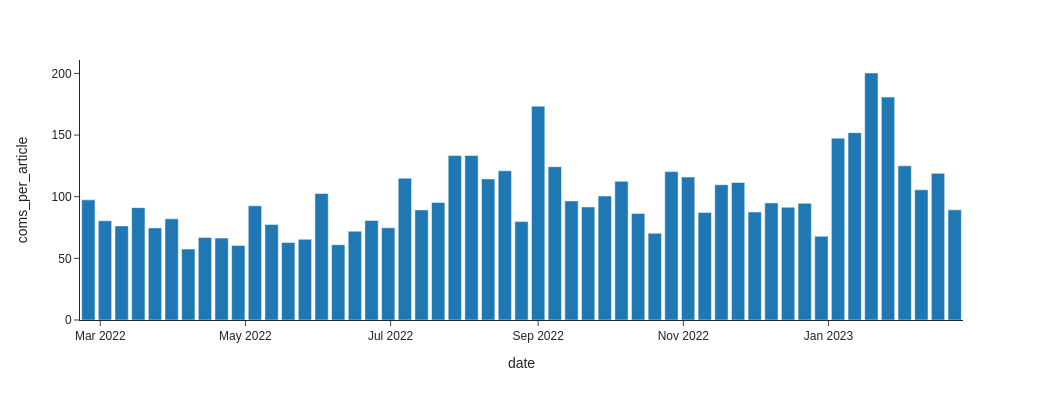

In [181]:
# weekly coms per article over time. TLDR : comments activity keeps being high throughout the "first" year of conflict, whatever the articles frequency
px.bar(weekly_coms_per_articles.to_pandas(), x="date", y="coms_per_article", width=600, height=400, template=template)

In [178]:
# moving (rolling) mean, another way to --kind of, smoothen out coms frequency without the hastle above
moving_mean = coms_daily_count.with_columns(pl.col('count').rolling_mean(window_size = 30).alias('moving_mean'))
moving_mean

date,count,moving_mean
date,u32,f64
2022-02-24,3762,null
2022-02-25,2735,null
2022-02-26,785,null
2022-03-01,75,null
2022-03-02,243,null
…,…,…
2023-02-22,1770,769.2
2023-02-23,1404,795.866667
2023-02-24,2322,819.466667


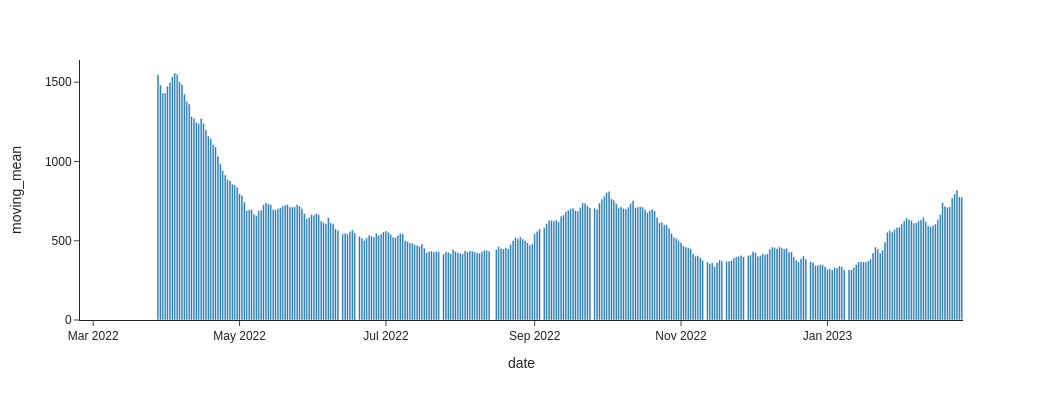

In [180]:
px.bar(moving_mean.to_pandas(), x="date", y="moving_mean", width=600, height=400, template=template)

## Who are the most active comments authors ?

In [ ]:
# top commentators

In [ ]:
authors = coms.groupby('author').count().sort('count', descending=True)
print(authors.head(10))

In [ ]:
authors.describe()

In [ ]:
px.violin(authors.to_pandas(), y = 'count', box=True, points='all', width=800, height=400, template=template)

In [ ]:
# too many 'outliers' to visualize with a std box, cut authors in half. or visualize as 'points' as above
px.box(authors.to_pandas()[5000:], y='count', width=800, height=400, template=template)

In [ ]:
# same but with a filter on posts count
px.box(authors.filter(pl.col('count') <= 100).to_pandas(), y='count', width=800, height=400, template=template)

In [ ]:
# histogram (filtered)
px.histogram(authors.filter(pl.col('count') <= 200).to_pandas(), x='count', width=800, height=400, template=template)

In [ ]:
# A few highlights on authors' contents

In [ ]:
authors.head(10)

In [ ]:
# As a comments reader, "goupil hardi" rings a bell, he acts kind of like a "troll/fact checker"
# Second top poster with 2034 comments in 365 days (more than 5 comments a day, on Ukraine only)
# he inspired me to analyse some figures as he seems to do all his work manually. e.g counting + citing "trolls" messages/authors
coms.select(["author", "date", "comment"]).filter(pl.col('author') == "goupil hardi").sample(10)

In [ ]:
# what about Lux, the top poster ? Don't remember about him
# looks like a strong supporter of Ukraine + wary about "propagandists". Superficial analysis I know. Just curious.
coms.select(["author", "date", "comment"]).filter(pl.col('author') == "Lux").sample(10)

In [ ]:
# Denis Monod-Broca, also a name I remember of. To the very least a strong defender of Russian invasion.
coms.select(["author", "date", "comment"]).filter(pl.col('author') == "Denis Monod-Broca").sample(10)

In [ ]:
# Could also do a lot of interesting stuff on trolls (if they exist) but out of this overview scope

In [ ]:
# cohort analysis, "retention rate" of commentators over time (here on a monthly basis)

In [ ]:
# keep relevant columns only
cohort = coms.clone()
cohort.head(1)

In [ ]:
relevant_columns = ['author', 'date', 'article_id']
cohort = cohort.select(relevant_columns)
# switch to Pandas for now, more familiar with it
cohort = cohort.to_pandas()
cohort.head(3)

## Engagement through cohort analysis, what's about the retention rate ?

In [ ]:
# Steps
# 1. add/get comment month -> month of the comment for each author
# 2. add/get cohort month (first month that user posted a comment) -> first month the authors commented
# 3. add/get cohort index for each row

In [ ]:
# 1. comment month
# tip : map faster than apply, we can use it cause we're dealin with one col at a time
cohort['comment_month'] = cohort['date'].map(lambda x: datetime(x.year, x.month, 1))
display(cohort.head(1))
# 2. cohort month
# tip : transform after a groupby,return a df with the same length and here return the min for each entry
cohort['cohort_month'] = cohort.groupby('author')['comment_month'].transform('min')
display(cohort.head(3))

In [ ]:
# 3. cohort index (for each row, difference in months, between first comment month and cohort month
def get_date(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    day = df[column].dt.day
    return year, month, day

comment_year, comment_month, _ = get_date(cohort, 'comment_month')
cohort_year, cohort_month, _ = get_date(cohort, 'cohort_month')
year_diff = comment_year - cohort_year
month_diff = comment_month - cohort_month
cohort['cohort_index'] = year_diff * 12 + month_diff + 1
display(cohort.head(5))

In [ ]:
# cohort active users (active authors / retention rate)
active_authors = cohort.groupby(['cohort_month', 'cohort_index'])['author'].apply(pd.Series.nunique).reset_index()
active_authors = active_authors.pivot_table(index = 'cohort_month',
                                       columns = 'cohort_index',
                                       values = 'author')
active_authors

In [ ]:
fig = px.imshow(active_authors, text_auto=True, width=800, height=500)
fig.show()

In [ ]:
active_authors_pct = active_authors.copy(deep=True)
active_authors_pct

In [ ]:
# pct active users
active_authors_pct = active_authors.copy(deep=True)
for col in active_authors_pct.columns[1:]:
    active_authors_pct[col] = round(active_authors_pct[col] / active_authors_pct[1] *100, 2)
active_authors_pct[1] = 100
active_authors_pct.head(2)

In [ ]:
labels = {"x":"n months", "y":"cohort (by month)", "color": "% author"}

fig = px.imshow(active_authors_pct, text_auto=True, labels = labels)
fig.update_xaxes(side="top", ticks="outside",tickson="boundaries",ticklen=5)
fig.update_yaxes(showgrid=False)

fig.update_layout({
    "xaxis" : {'tickmode':'linear', "showgrid":False},
    "width":800,
    "height":500,
    "plot_bgcolor":'rgba(0, 0, 0, 0)',
    "paper_bgcolor":'rgba(0, 2, 0, 0)'
})
fig.show()

## NLP stuff

### Sampling to iterate faster on our Faiss/SBERT models experiments

In [ ]:
# Remember, our dataset was loaded as a Polars dataframe, sample method is very similar though.
coms_sample = coms.sample(seed=42, n=20000, shuffle=True)
# We're removing articles content and some other cols we won't work with
keep_cols= ['article_id', 'url', 'title', 'desc', 'date', 'keywords', 'author', 'comment']
coms_sample = coms_sample.select(pl.col(keep_cols))
print(coms_sample.shape)
display(coms_sample.head(1))

In [ ]:
# Quick cleaning, add "weird" semantic search results when keeping short comments with emojis
# Just filter out small comments
coms_sample = coms_sample.filter(pl.col("comment").str.n_chars() >= 45)
print(coms_sample.shape)
display(coms_sample.head(1))

In [ ]:
# For later stages, as we will perform semantic search on comments, let's add a simple, order "id" column to our comments
comment_ids = list(range(0,coms_sample.shape[0]))
coms_sample = coms_sample.with_columns(
    pl.Series(name='comment_id', values=comment_ids)
)
print(coms_sample.shape)
display(coms_sample.head(2))

In [ ]:
# convert back to Pandas, for "better/faster" flow with embeddings and FAISS
coms_sample = coms_sample.to_pandas()
coms_sample.head(1)

### Semantic search using SBERT & FAISS. + some benchmarking

In [ ]:
# Model choice, must read : symmetric vs. asymmetric semantich search, langage, tuning (https://medium.com/mlearning-ai/semantic-search-with-s-bert-is-all-you-need-951bc710e160)
# Models details : https://www.sbert.net/docs/pretrained_models.html
# Notes :
# Models trained for cosine prefers shorter document retrieval, vs. dot product (longer)
# Faiss uses inner product(=dotproduct) (+= cosine if vectors are normalized : before must use faiss.normalize_L2) or L2 to measure distance
# see : https://github.com/facebookresearch/faiss/wiki/MetricType-and-distances#how-can-i-index-vectors-for-cosine-similarity
# Check for each model, the max sentence length
# Our needs :
# We want mainly to retrieve equal or longer document : dot product
# We're not sure of our use case yet : short query => long document (asymmetric), or long => long (symmetric)

In [ ]:
# load model(s) from sentenceTransformer, candidates models below
# may also try a model optimized for french ? e.g. https://huggingface.co/dangvantuan/sentence-camembert-large (-> model4)
# For asymmetric, look up for MS MARCO models

model1 = SentenceTransformer('paraphrase-multilingual-mpnet-base-v2')  # multi languages, suitable score : cosine, , max seq len 128
model2 = SentenceTransformer('distiluse-base-multilingual-cased-v1') # symmetric, multilanguages, max seq len 128, optimized for cosine
model3 = SentenceTransformer('quora-distilbert-multilingual') # symmetric, multilanguages, short text (questions) closest to our symm use case ?
# e.g of use : https://github.com/UKPLab/sentence-transformers/blob/master/examples/applications/semantic-search/semantic_search_quora_pytorch.py
model4 = SentenceTransformer('dangvantuan/sentence-camembert-large') # symmetric ?, french, l2 + tbc others ? To be used with Torch ?

In [ ]:
model1

In [ ]:
model4

In [ ]:
# Comments embeddings
def comments_to_list(df, column):
    """ Extract a given df column with documents to a List"""
    return df[column].values.tolist()

def load_model(model_name):
    return SentenceTransformer(model_name)

def encode_comments(model, comments):
    return model.encode(comments, show_progress_bar=True)

In [ ]:
# create index
def create_faiss_index(embeddings, normalize, index_type):
    """ 
    Create a flat index in Faiss (IP or L2)
    Index_types and prior vectors normalization varies according to task/model we want to perform/use
    """
    dimension = embeddings.shape[1]    
    embeddings = np.array(embeddings).astype("float32")
    if normalize:
        faiss.normalize_L2(embeddings)
    if index_type == 'ip':
        index=faiss.IndexFlatIP(dimension)
        index.add(embeddings)
    else:
        index = faiss.IndexFlatL2(dimension)
        index.add(embeddings)
    return index

def save_index(index, filename):
    faiss.write_index(index, f"{filename}.index")
    
def load_index(filename):
    return faiss.load_index(filename)

In [ ]:
# query index
  
def search_index(index, model, query, normalize, top_k):
    # encode query
    vector = model.encode([query])
    if normalize:
        faiss.normalize_L2(vector)
    
    # search with Faiss
    Distances, Indexes = index.search(vector, top_k)
    # Distances, Indexes = index.search(np.array(vector).astype("float32"), top_k)
    return Distances, Indexes
      
def index_to_comments(df, column, Indexes):
    """ Convenience function to retrieve top K comments directly from our dataset """
    return df.iloc[Indexes[0]][column].tolist()

In [ ]:
# load comments, model, encode with model
comments = comments_to_list(coms_sample, "comment")
model = load_model('dangvantuan/sentence-camembert-large')
embeddings = encode_comments(model, comments)

In [ ]:
# create Faiss Index
normalize = False
index = create_faiss_index(embeddings, normalize, index_type="ip")

In [ ]:
# extract an existing comment (= our query) from dataset
coms_sample['comment'].tolist()[1300]

In [ ]:
# encode query, query index
query = "Quelle arrogance et quel cynisme. Qu'y a t-il de plus terroriste que la Russie d'aujourd'hui?"
top_k = 10
Distances, Indexes = search_index(index, model, query, normalize, top_k)

In [ ]:
# display top nearest comments
results = index_to_comments(coms_sample, "comment", Indexes)
results

#### Quick notes, after testing the different models
- mpnet-base-v2, distiluse, quora : fast encoding (20k documents < 1mn), results quite similar between models, each one finds our test query and pertinent results. they're are a very good baseline.
- mpnet-base-v2, distiluse, quora : with a flat inner product faiss index, no difference if we perform vectors normalization or not, maybe because they're optimized for cosine already?
- camembert is a bigger model (1024 dimension), slower encoding (20k docs = 5mn), nice (better?) results (optimized on French). With a flat IP index, if normalize = False, retrieve similar, short documents. If we decided to normalize our embeddings, retrieve longer, similar, documents.

### Maybe later just for fun : 0 shot "tone" classification using OpenAI API